In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import cosine_similarity
sns.set_style("darkgrid")

In [2]:
# Skip date
df1 = pd.read_csv('combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


In [3]:
#df2 = pd.read_csv('combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df3 = pd.read_csv('combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df4 = pd.read_csv('combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


#df2['Rating'] = df2['Rating'].astype(float)
#df3['Rating'] = df3['Rating'].astype(float)
#df4['Rating'] = df4['Rating'].astype(float)

#print('Dataset 2 shape: {}'.format(df2.shape))
#print('Dataset 3 shape: {}'.format(df3.shape))
#print('Dataset 4 shape: {}'.format(df4.shape))

In [4]:
df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


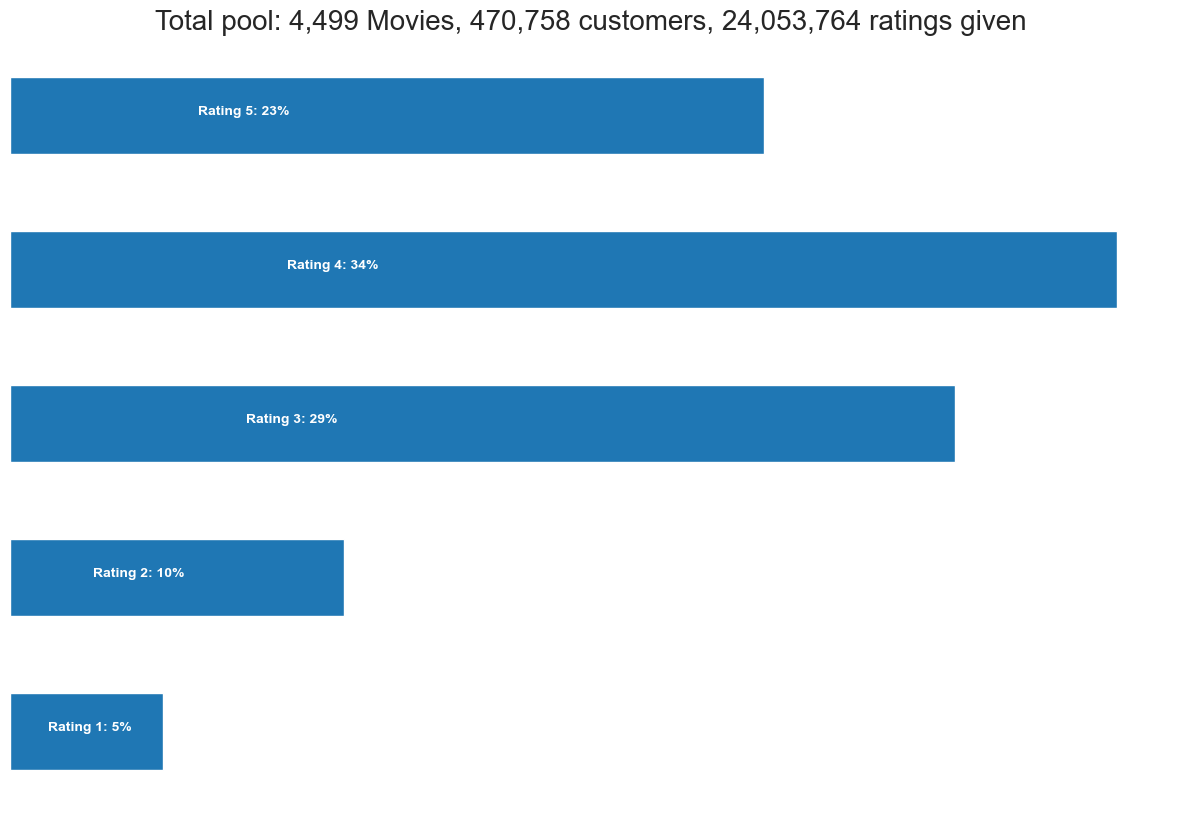

In [5]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [6]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [7]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

/var/folders/_k/_rt6thqx6mj63rxtq_q_l7j00000gn/T/ipykernel_30296/2609185946.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie_Id'] = movie_np.astype(int)


-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


/var/folders/_k/_rt6thqx6mj63rxtq_q_l7j00000gn/T/ipykernel_30296/2609185946.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cust_Id'] = df['Cust_Id'].astype(int)


In [8]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1799.0
Customer minimum times of review: 52.0


In [9]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (17337458, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6932490   1299309     5.0      1384
13860273   400155     3.0      2660
20766530   466962     4.0      3923


In [10]:
customers_list = df['Cust_Id'].value_counts()[:3000].index.tolist()

df = df[df['Cust_Id'].isin(customers_list)]

In [11]:
df['Cust_Id'].value_counts(ascending=False)

305344     1344
387418     1339
2439493    1324
2118461    1305
1664010    1257
           ... 
287901      352
2473345     352
1033629     352
1573486     352
520507      352
Name: Cust_Id, Length: 3000, dtype: int64

In [12]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(3000, 1350)


In [13]:
df_p

Movie_Id,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
Cust_Id,,,,,,,,,,,,,,,,,,,,,
1333,4.0,3.0,NaN,NaN,4.0,3.0,2.0,3.0,NaN,NaN,...,5.0,NaN,NaN,3.0,2.0,4.0,NaN,NaN,NaN,2.0
2213,NaN,NaN,3.0,NaN,NaN,NaN,5.0,NaN,5.0,NaN,...,4.0,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN
3321,NaN,1.0,3.0,2.0,NaN,NaN,4.0,5.0,2.0,NaN,...,2.0,NaN,NaN,4.0,3.0,3.0,NaN,NaN,NaN,NaN
3998,NaN,NaN,NaN,NaN,4.0,NaN,5.0,5.0,NaN,3.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4597,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN,...,2.0,NaN,NaN,3.0,NaN,5.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2645579,NaN,NaN,NaN,NaN,NaN,3.0,4.0,3.0,NaN,NaN,...,NaN,NaN,NaN,3.0,4.0,3.0,NaN,2.0,3.0,NaN
2646347,NaN,NaN,NaN,NaN,4.0,NaN,4.0,2.0,NaN,NaN,...,4.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,3.0
2646574,NaN,NaN,NaN,NaN,NaN,3.0,4.0,4.0,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN


In [14]:
df_title = pd.read_csv('movie_titles.csv', usecols=range(3), lineterminator='\n', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


In [15]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.82065688, 0.82059073, 0.82106928, 0.82237773, 0.82360135]),
 'test_mae': array([0.63620175, 0.63625628, 0.63643013, 0.63668342, 0.63753607]),
 'fit_time': (7.872559070587158,
  9.31452989578247,
  8.506659030914307,
  8.943928241729736,
  9.17637825012207),
 'test_time': (1.8570101261138916,
  1.2826192378997803,
  1.7039058208465576,
  1.4860007762908936,
  1.288468837738037)}

In [16]:
df_305344 = df[(df['Cust_Id'] == 305344) & (df['Rating'] == 5)]
df_305344 = df_305344.set_index('Movie_Id')
df_305344 = df_305344.join(df_title)['Name']
print(df_305344)

Movie_Id
83                                         Silkwood
199                                 The Deer Hunter
208     The Three Stooges: Sing a Song of Six Pants
238         Led Zeppelin: The Song Remains the Same
344                         The Taming of the Shrew
                           ...                     
4219                            The Tuskegee Airmen
4266                      The Passion of the Christ
4302                     An Officer and a Gentleman
4386                  The Return of the Living Dead
4432                                The Italian Job
Name: Name, Length: 81, dtype: object


In [17]:
user_305344 = df_title.copy()
user_305344 = user_305344.reset_index()
user_305344 = user_305344[~user_305344['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_305344['Estimate_Score'] = user_305344['Movie_Id'].apply(lambda x: svd.predict(305344, x).est)

user_305344 = user_305344.drop('Movie_Id', axis = 1)

user_305344 = user_305344.sort_values('Estimate_Score', ascending=False)
print(user_305344.head(10))

        Year                            Name  Estimate_Score
198   1978.0                 The Deer Hunter        4.779188
3223  1930.0  All Quiet on the Western Front        4.382685
3797  1973.0                       The Sting        4.340813
707   2000.0               The Perfect Storm        4.296831
3289  1974.0                   The Godfather        4.275078
2417  1960.0               Sink the Bismarck        4.162668
1798  1990.0          Die Hard 2: Die Harder        4.162327
797   1975.0                            Jaws        4.097237
661   1995.0                         Rob Roy        4.097216
2847  1961.0                     The Hustler        4.074414


In [18]:
def recommend(movie_title, min_count):
    #print("For movie ({})".format(movie_title))
    #print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    result_df = corr_target[corr_target['count']>min_count][:10]
    return result_df

In [19]:
recommend("What the #$*! Do We Know!?", 0)

,PearsonR,Name,count,mean
Movie_Id,,,,
8,1.000000,What the #$*! Do We Know!?,14910,3.189805
3559,0.730537,Cowboys & Angels,2368,3.589527
1375,0.652755,Food of Love,1891,3.325225
242,0.643694,Neon Genesis Evangelion: The End of Evangelion,2375,3.911158
4390,0.623863,Get Your Stuff,1826,3.111172
178,0.623628,Regular Guys,1931,3.372864
2870,0.617247,Captain Pantoja and the Special Services,1801,3.417546
3841,0.600568,Tenchi the Movie: Tenchi Muyo! In Love,2148,3.457635
180,0.599473,Scratch,2418,3.833747


In [20]:
recommend("X2: X-Men United", 0)

,PearsonR,Name,count,mean
Movie_Id,,,,
191,1.000000,X2: X-Men United,98720,3.932202
4238,0.599533,Inu-Yasha,1883,4.554434
2651,0.496658,Dragon Ball Z: Super Android 13,2426,3.428689
1375,0.494894,Food of Love,1891,3.325225
3841,0.472351,Tenchi the Movie: Tenchi Muyo! In Love,2148,3.457635
4463,0.465234,Escaflowne: The Movie,1992,3.629016
3475,0.463737,Batman Beyond: The Movie,2614,3.726855
4390,0.462412,Get Your Stuff,1826,3.111172
178,0.449944,Regular Guys,1931,3.372864


In [21]:
df_title.to_csv('df_title.csv', index=None)

In [22]:
df_movie_summary.to_csv('df_movie_summary.csv', index=None)

In [23]:
df.to_csv('df.csv', index=None)

In [24]:
df_wide = pd.pivot_table(df, values=['Rating'],
        index=['Movie_Id', 'Cust_Id'],
        aggfunc=np.mean).unstack()
df_wide.shape

(1350, 3000)

In [25]:
df_wide = df_wide.fillna(0)
df_wide

Rating                                                          \
Cust_Id  1333    2213    3321    3998    4597    4905    5530    5980      
Movie_Id                                                                   
3            4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
8            3.0     0.0     1.0     0.0     0.0     0.0     0.0     3.0   
16           0.0     3.0     3.0     0.0     0.0     0.0     0.0     0.0   
17           0.0     0.0     2.0     0.0     0.0     0.0     0.0     3.0   
18           4.0     0.0     0.0     4.0     0.0     0.0     0.0     4.0   
...          ...     ...     ...     ...     ...     ...     ...     ...   
4488         4.0     4.0     3.0     0.0     5.0     4.0     4.0     3.0   
4490         0.0     0.0     0.0     0.0     0.0     2.0     0.0     0.0   
4492         0.0     0.0     0.0     0.0     0.0     0.0     4.0     0.0   
4493         0.0     0.0     0.0     0.0     0.0     0.0     4.0     5.0   
4496         2.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                          ...                                                  \
Cust_Id  6206    6629     ... 2640278 2640550 2640760 2641668 2644964 2645579   
Movie_Id                  ...                                                   
3            0.0     0.0  ...     0.0     0.0     0.0     4.0     0.0     0.0   
8            0.0     0.0  ...     0.0     3.0     0.0     0.0     0.0     0.0   
16           0.0     0.0  ...     3.0     0.0     4.0     0.0     3.0     0.0   
17           0.0     0.0  ...     0.0     3.0     0.0     0.0     4.0     0.0   
18           0.0     0.0  ...     0.0     0.0     0.0     3.0     0.0     0.0   
...          ...     ...  ...     ...     ...     ...     ...     ...     ...   
4488         3.0     3.0  ...     0.0     0.0     4.0     0.0     2.0     3.0   
4490         0.0     3.0  ...     0.0     0.0     0.0     0.0     3.0     0.0   
4492         0.0     0.0  ...     4.0     3.0     0.0     0.0     0.0     2.0   
4493         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     3.0   
4496         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

                                          
Cust_Id  2646347 2646574 2647197 2647888  
Movie_Id                                  
3            0.0     0.0     0.0     0.0  
8            0.0     0.0     1.0     0.0  
16           0.0     0.0     0.0     0.0  
17           0.0     0.0     0.0     0.0  
18           4.0     0.0     4.0     0.0  
...          ...     ...     ...     ...  
4488         0.0     0.0     0.0     0.0  
4490         0.0     3.0     0.0     0.0  
4492         0.0     0.0     0.0     4.0  
4493         0.0     0.0     0.0     0.0  
4496         3.0     0.0     0.0     0.0  

[1350 rows x 3000 columns]

In [26]:
cosine_sim = cosine_similarity(df_wide)
cosine_sim

array([[1.        , 0.13817874, 0.09503858, ..., 0.06583673, 0.14541076,
        0.30691266],
       [0.13817874, 1.        , 0.16157873, ..., 0.15000609, 0.21064832,
        0.29183025],
       [0.09503858, 0.16157873, 1.        , ..., 0.31532729, 0.24001338,
        0.17515975],
       ...,
       [0.06583673, 0.15000609, 0.31532729, ..., 1.        , 0.26428706,
        0.10651123],
       [0.14541076, 0.21064832, 0.24001338, ..., 0.26428706, 1.        ,
        0.20931245],
       [0.30691266, 0.29183025, 0.17515975, ..., 0.10651123, 0.20931245,
        1.        ]])

In [27]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_wide.index, columns=df_wide.index)
cosine_sim_df.head()

Movie_Id,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
Movie_Id,,,,,,,,,,,,,,,,,,,,,
3,1.000000,0.138179,0.095039,0.040419,0.235293,0.089734,0.118484,0.178801,0.057299,0.088486,...,0.195857,0.101442,0.226177,0.242202,0.152962,0.243777,0.145335,0.065837,0.145411,0.306913
8,0.138179,1.000000,0.161579,0.127620,0.294765,0.152770,0.234174,0.332585,0.093226,0.148834,...,0.340127,0.189407,0.186942,0.334453,0.172840,0.367002,0.213542,0.150006,0.210648,0.291830
16,0.095039,0.161579,1.000000,0.195732,0.268767,0.221968,0.351556,0.336656,0.125586,0.197304,...,0.309021,0.389569,0.107273,0.263290,0.298611,0.303236,0.203779,0.315327,0.240013,0.175160
17,0.040419,0.127620,0.195732,1.000000,0.121624,0.292012,0.242177,0.300068,0.207550,0.072822,...,0.225278,0.252000,0.037871,0.203583,0.152479,0.193333,0.202114,0.177606,0.155073,0.089637
18,0.235293,0.294765,0.268767,0.121624,1.000000,0.166056,0.429169,0.530994,0.141197,0.223619,...,0.542894,0.287300,0.251284,0.536896,0.332020,0.570680,0.325622,0.233335,0.253021,0.498607


In [28]:
def find_similar_movies(movies, count=1):
    temp_df = pd.DataFrame(movies,columns=["Name"])
    input_df = pd.merge(temp_df, 
                      df_title, 
                      on ='Name', 
                      how ='left')
    movies = list(input_df["movie_id"])

    movies = [movie for movie in movies if movie in cosine_sim_df.columns]
    movies_summed = cosine_sim_df[movies].apply(lambda row: np.sum(row), axis=1)
    movies_summed = movies_summed.sort_values(ascending=False) # Yüksek skorlar daha iyi
    ranked_movies = movies_summed.index[movies_summed.index.isin(movies)==False]
    ranked_movies = ranked_movies.tolist()

    if count is None:
        temp = ranked_movies
    else:
        temp = ranked_movies[:count]
    
    temp_df = pd.DataFrame(temp,columns=["movie_id"])
    df_title['movie_id'] = df_title.index
    result = pd.merge(temp_df, 
                      df_title, 
                      on ='movie_id', 
                      how ='left')
    return pd.DataFrame(result["Name"])

In [29]:
find_similar_movies(["Character"], 10)

KeyError: 'movie_id'